In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("C:\\Users\\user\\Documents\\MSc\\F1_KutMod\\kutmod\\saját_kutatás\\books.csv")

In [7]:
text_features = ['title']
categorical_features = ['authors']
numeric_features = ['num_pages', 'ratings_count']
target = 'average_rating'

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=1000, stop_words='english'), 'title'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

In [15]:
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

In [16]:
X = df[text_features + categorical_features + numeric_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

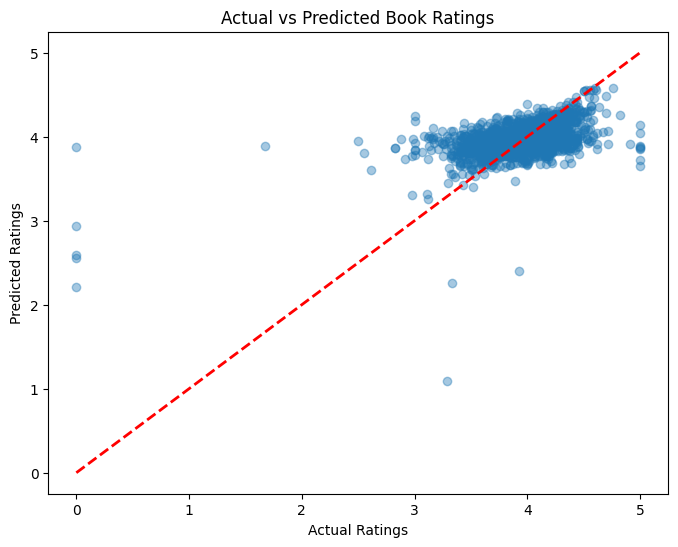

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         'r--', linewidth=2)  # line y=x
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Book Ratings")
plt.show()

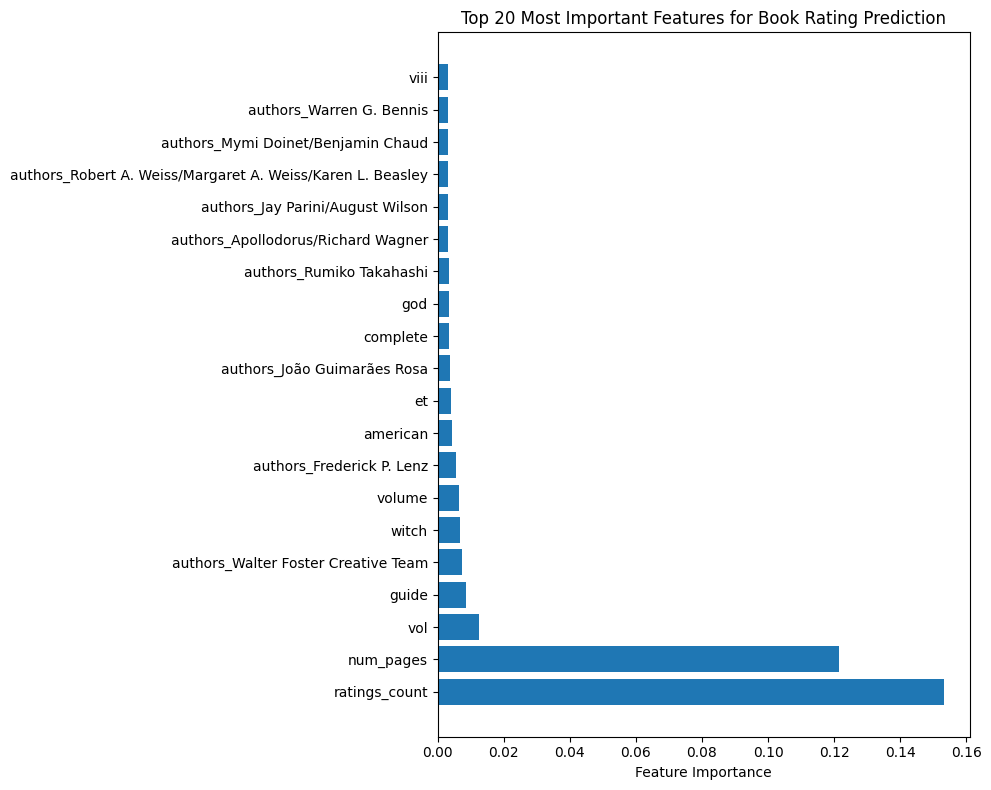

In [23]:
import numpy as np

# Get feature names from the preprocessor
feature_names = []

# Text features from TfidfVectorizer
tfidf = model.named_steps['preprocess'].named_transformers_['text']
text_feature_names = tfidf.get_feature_names_out()
feature_names.extend(text_feature_names)

# Categorical features from OneHotEncoder
ohe = model.named_steps['preprocess'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names.extend(cat_feature_names)

# Numeric features
feature_names.extend(numeric_features)

# Get feature importances from Random Forest
importances = model.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[::-1]

# Visualize top 20 most important features
plt.figure(figsize=(10, 8))
plt.barh(range(min(20, len(feature_names))), importances[indices[:min(20, len(feature_names))]])
plt.yticks(range(min(20, len(feature_names))), [feature_names[indices[i]] for i in range(min(20, len(feature_names)))])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features for Book Rating Prediction")
plt.tight_layout()
plt.show()


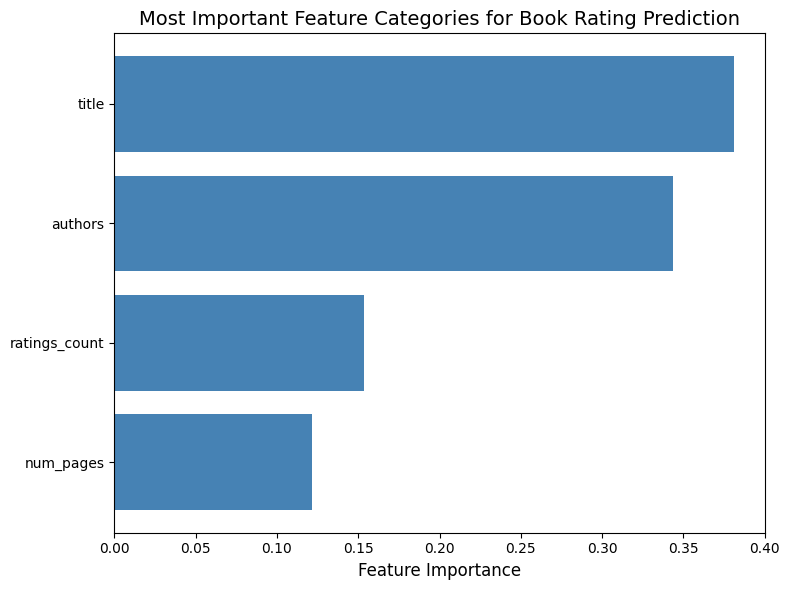

In [28]:
# Aggregate TF-IDF features into single "title" importance
title_importance = importances[:n_text_features].sum()

# Aggregate all author one-hot encoded features into single "authors" importance
n_author_features = len(cat_feature_names)
authors_importance = importances[n_text_features:n_text_features + n_author_features].sum()

# Numeric feature importances
numeric_importances = importances[n_text_features + n_author_features:]

# Create aggregated feature importances and names
aggregated_importances = np.concatenate([[title_importance, authors_importance], numeric_importances])
aggregated_feature_names = ['title', 'authors'] + numeric_features

# Get top indices
agg_indices = np.argsort(aggregated_importances)[::-1]

# Visualization of top features
plt.figure(figsize=(8, 6))
top_n = min(5, len(aggregated_feature_names))
top_indices = agg_indices[:top_n]
top_importances = aggregated_importances[top_indices]
top_feature_names = [aggregated_feature_names[i] for i in top_indices]

plt.barh(range(top_n), top_importances, color='steelblue')
plt.yticks(range(top_n), top_feature_names)
plt.xlabel("Feature Importance", fontsize=12)
plt.title(f"Most Important Feature Categories for Book Rating Prediction", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
